In [1]:
import sys
sys.path.insert(0, '/openpose/data/other/humor/humor')
sys.path.insert(0, '/openpose/data/code/reprojection/')
from fitting.fitting_utils import load_res, run_smpl
from body_model.body_model import BodyModel
import json

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# MATLAB intrinsics to OpenCV intrinsics
omni_intrinsics_file = "/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/omni_intrinsics.pkl"
with open(omni_intrinsics_file, 'rb') as f:
    omni = pickle.load(f)

omni

{'intrinsics': array([[1.03422193e+03, 3.15963412e+00, 6.30338627e+02],
        [0.00000000e+00, 1.04598893e+03, 4.40469792e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distortion': array([[-0.36459099,  0.31589191,  0.00289702, -0.00329105]]),
 'xi': array([[1.9408733]]),
 'img_shape': (900, 1200)}

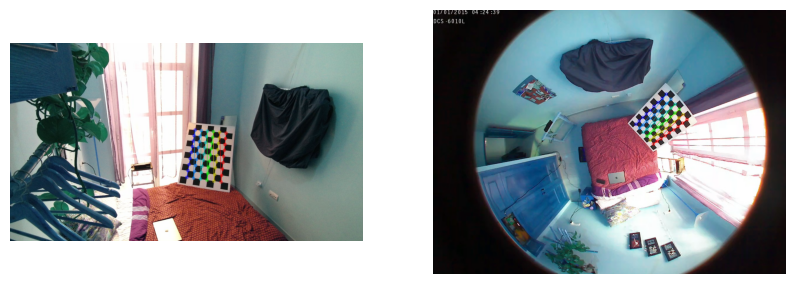

In [3]:
# Validating extrinsion matrix
side_image = cv2.imread('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/rgb/1674139466690.jpg')
top_image = cv2.imread('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/omni/1674139525274.jpg')

# side_image = cv2.imread('/openpose/data/dataset/session-recordings/2022-09-22/at-paus/living-room/calib/k1-omni/rgb/1663859132529.jpg')
# top_image = cv2.imread("/openpose/data/dataset/session-recordings/2022-09-22/at-paus/living-room/calib/k1-omni/omni/1663858909893.jpg")

pattern_size = (9, 6)

# Find the checkerboard corners in both images
ret1, side_corners_img = cv2.findChessboardCorners(side_image, pattern_size, None)
ret2, top_corners_img = cv2.findChessboardCorners(top_image, pattern_size, None)

# Draw the corners on both images
side_image = cv2.drawChessboardCorners(side_image, pattern_size, side_corners_img, ret1)
top_image = cv2.drawChessboardCorners(top_image, pattern_size, top_corners_img, ret2)

# Display the images
temp1 = Image.fromarray(side_image)
temp2 = Image.fromarray(top_image)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(temp1)
axes[0].axis('off')
axes[1].imshow(temp2)
axes[1].axis('off')

plt.show()

In [4]:
# Load all matrices - new sequence
with open('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_rgb_cam_to_world.pkl', 'rb') as f:
    rgb_cam_to_world = pickle.load(f)

with open('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_omni_cam_to_world.pkl', 'rb') as f:
    omni_cam_to_world = pickle.load(f)

with open('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_rgb_world_to_cam.pkl', 'rb') as f:
    rgb_world_to_cam = pickle.load(f)

with open('/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_omni_world_to_cam.pkl', 'rb') as f:
    omni_world_to_cam = pickle.load(f)

# with open("/openpose/data/code/reprojection/calibration/intrinsics/k1_rgb_calib.pkl", "rb") as f:
#     rgb_intrinsics = pickle.load(f)

# with open("/openpose/data/code/reprojection/calibration/intrinsics/omni_calib.pkl", "rb") as f:
#     omni_intrinsics = pickle.load(f)

with open("/openpose/data/code/reprojection/calibration/intrinsics/k0_rgb_intrinsics_new.pkl", "rb") as f:
    rgb_intrinsics = pickle.load(f)

with open("/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/omni_intrinsics.pkl", "rb") as f:
    omni_intrinsics_old = pickle.load(f)


omni_intrinsics = omni_intrinsics_old.copy()

omni_intrinsics["intrinsics"] = np.array([[450., 0, 600.], [0, 450., 450.], [0,0,1.]])
omni_intrinsics

{'intrinsics': array([[450.,   0., 600.],
        [  0., 450., 450.],
        [  0.,   0.,   1.]]),
 'distortion': array([[-0.36459099,  0.31589191,  0.00289702, -0.00329105]]),
 'xi': array([[1.9408733]]),
 'img_shape': (900, 1200)}

In [5]:
# # Put omni intrinsics which is a dict into a json file
# import json

# # Convert ndarray to list
# # omni_intrinsics["intrinsics"] = omni_intrinsics["intrinsics"].tolist()
# # omni_intrinsics["distortion"] = omni_intrinsics["distortion"].tolist()
# # omni_intrinsics["xi"] = omni_intrinsics["xi"].tolist()

# with open('/openpose/data/code/reprojection/calibration/intrinsics/omni_intrinsics.json', 'w') as fp:
#     json.dump(omni_intrinsics, fp)

In [6]:
omni_intrinsics

{'intrinsics': array([[450.,   0., 600.],
        [  0., 450., 450.],
        [  0.,   0.,   1.]]),
 'distortion': array([[-0.36459099,  0.31589191,  0.00289702, -0.00329105]]),
 'xi': array([[1.9408733]]),
 'img_shape': (900, 1200)}

In [7]:
#  Stack camera matrices to get to the correct format
def make_44(R, t):
    return np.vstack((np.hstack((R, t)), [0, 0, 0, 1]))

In [8]:
distances = 1 *np.ones((1, 54)) #0.18
count = 0 
# increment = 0
# # Increase the value of every 10th point by 0.01, 19th point by 0.02 and so on
# for i in range(len(distances[0])):
#     if count == 9:
#         increment += 0.02
#         count = 0
#     distances[0][i] = distances[0][i] + increment
#     count += 1 


In [9]:
# Get the camera coordinates

cameraMatrix = rgb_intrinsics["intrinsics"]
distCoeffs = rgb_intrinsics["distortion"]

# Convert 2D image coordinates to 3D camera coordinates
# Undistort using distortion coefficients
# side_corners_img = cv2.undistortPoints(src=side_corners_img, cameraMatrix=np.linalg.inv(cameraMatrix), distCoeffs=distCoeffs)
homogeneous_image_coordinates = np.concatenate((side_corners_img, np.ones((54, 1, 1))), axis=2)
camera_coordinates = np.linalg.inv(cameraMatrix) @ homogeneous_image_coordinates.reshape(54,3).T

homogeneous_camera_coordinates = np.vstack((camera_coordinates, distances))

In [10]:
# Reprojection error check
R_rgb_inv = rgb_world_to_cam["R"]
t_rgb_inv = rgb_world_to_cam["t"]
R_rgb = rgb_cam_to_world["R"]
t_rgb = rgb_cam_to_world["t"]

R_omni_inv = omni_world_to_cam["R"]
t_omni_inv = omni_world_to_cam["t"]
R_omni = omni_cam_to_world["R"]
t_omni = omni_cam_to_world["t"]

T_cw = make_44(R_rgb, t_rgb)
T_wc = make_44(R_omni_inv, t_omni_inv)

extrinsic_matrix = T_wc @ T_cw
extrinsic_matrix[:3, 3] = extrinsic_matrix[:3, 3] / 1000.0

omni_camera_coordinates = extrinsic_matrix @ homogeneous_camera_coordinates # np.linalg.inv(extrinsic_matrix)
omni_camera_coordinates = omni_camera_coordinates[:3, :].T
omni_camera_coordinates = omni_camera_coordinates.reshape(54, 1, 3)

In [11]:
K = omni_intrinsics["intrinsics"]
D = omni_intrinsics["distortion"]
xi = omni_intrinsics["xi"]

xi = xi.item() if isinstance(xi, np.ndarray) else xi
xii = np.double(xi)
rvec, tvec = np.zeros(3), np.zeros(3)

In [12]:
omni_camera_coordinates

array([[[-0.68208975,  0.86839397,  0.90065852]],

       [[-0.67265808,  0.86222905,  0.86920572]],

       [[-0.66349225,  0.85631803,  0.83882715]],

       [[-0.65458255,  0.85006111,  0.80810018]],

       [[-0.64572265,  0.844515  ,  0.77912824]],

       [[-0.6370528 ,  0.83896844,  0.75049803]],

       [[-0.62885747,  0.8333452 ,  0.72254397]],

       [[-0.62059981,  0.82796575,  0.69504862]],

       [[-0.61245734,  0.82267241,  0.66796275]],

       [[-0.65571361,  0.8899507 ,  0.90358925]],

       [[-0.64637689,  0.88338573,  0.87137047]],

       [[-0.63753694,  0.87714444,  0.84080591]],

       [[-0.62863499,  0.87101213,  0.81038487]],

       [[-0.62021718,  0.86490024,  0.7808848 ]],

       [[-0.61187349,  0.85894574,  0.75188713]],

       [[-0.60380023,  0.85325454,  0.72399401]],

       [[-0.59574767,  0.84757772,  0.69617192]],

       [[-0.58806293,  0.84206065,  0.66938746]],

       [[-0.62849576,  0.91199573,  0.90614585]],

       [[-0.61957694,  0.905209

In [13]:
omni_image_corners, _ = cv2.omnidir.projectPoints(objectPoints=omni_camera_coordinates, rvec=rvec, tvec=tvec, K=K, D=D, xi=xii)
omni_image_corners = omni_image_corners.astype(np.float32)

# omni_image_corners = np.swapaxes(omni_image_corners, 0, 1)
# Switch x and y axes on omni_image_corners which is of 54, 1, 2 shape
# omni_image_corners = omni_image_corners[:, :, ::-1]
# print(omni_image_corners.shape)

#Draw omni_image_corners on top_image
# top_image = cv2.drawChessboardCorners(top_image, pattern_size, omni_image_corners, ret2)
# plt.imshow(top_image)

# Trying MATLAB

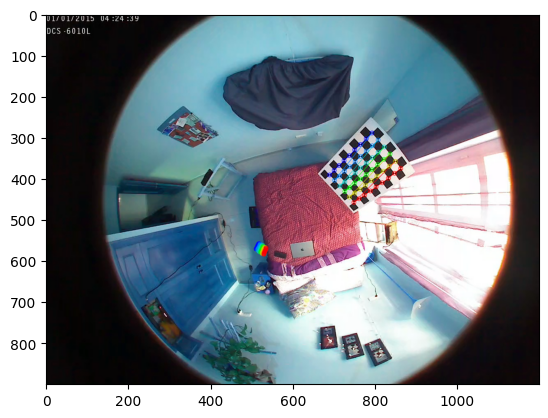

In [14]:
# Load from matlab
# intrinsics

with open("/openpose/data/dataset/session-recordings/test/2022-10-07/at-paus/bedroom/calib/matrices_matlab/k0_intrinsics.json", "rb") as f:
    k1_intrinsics = json.load(f)

with open("/openpose/data/dataset/session-recordings/test/2022-10-07/at-paus/bedroom/calib/matrices_matlab/omni_intrinsics.json", "rb") as f:
    omni_intrinsics_mat = json.load(f)

# extrinsics
with open("/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_omni_extrinsics.json", "rb") as f:
    k1_omni_extrinsics = json.load(f)

with open("/openpose/data/dataset/session-recordings/2023-01-19/at-a06/bedroom/calib/k0-omni/k0_rgb_extrinsics.json", "rb") as f:
    k1_extrinsics = json.load(f)


cameraMatrix_mat = np.array(k1_intrinsics["K"])

radial = np.array(k1_intrinsics["RadialDistortion"])
tangential = np.array(k1_intrinsics["TangentialDistortion"])
distCoeffs_mat = np.array([radial[0], radial[1], tangential[0], tangential[1]])

homogeneous_image_coordinates = np.concatenate((side_corners_img, np.ones((54, 1, 1))), axis=2)
camera_coordinates = np.linalg.inv(cameraMatrix_mat) @ homogeneous_image_coordinates.reshape(54,3).T
homogeneous_camera_coordinates = np.vstack((camera_coordinates, distances))


# RGB extrinsics
patternExtrinsics = np.array(k1_extrinsics["PatternExtrinsics"])
t_rgb_inv = np.array(patternExtrinsics[0]["Translation"])
t_rgb_inv = t_rgb_inv.reshape(3, 1)
R_rgb_inv = np.array(patternExtrinsics[0]["R"])

T_wc_mat_rgb = make_44(R_rgb_inv, t_rgb_inv)
T_cw_mat = np.linalg.inv(T_wc_mat_rgb)

# Omni extrinsics
R_wc_omni = np.array(k1_omni_extrinsics["RotationMatrices"]).T[0]
t_wc_omni = np.array(k1_omni_extrinsics["TranslationVectors"])[0]
t_wc_omni = t_wc_omni.reshape(3, 1)
T_wc_mat = make_44(R_wc_omni, t_wc_omni)

extrinsic_matrix_mat = T_wc_mat @ T_cw_mat
extrinsic_matrix_mat[:3, 3] = extrinsic_matrix_mat[:3, 3] / 1000.0

# Apply extrinsics to camera coordinates
omni_camera_coordinates = extrinsic_matrix_mat @ homogeneous_camera_coordinates # np.linalg.inv(extrinsic_matrix)
omni_camera_coordinates = omni_camera_coordinates[:3, :].T
omni_camera_coordinates = omni_camera_coordinates.reshape(54, 1, 3)

omni_image_corners_mat, _ = cv2.omnidir.projectPoints(objectPoints=omni_camera_coordinates, rvec=rvec, tvec=tvec, K=K, D=D, xi=xii)
omni_image_corners_mat = omni_image_corners_mat.astype(np.float32)
# omni_image_corners = np.swapaxes(omni_image_corners, 0, 1)
# Switch x and y axes on omni_image_corners which is of 54, 1, 2 shape
# omni_image_corners = omni_image_corners[:, :, ::-1]
# print(omni_image_corners.shape)

# Draw omni_image_corners on top_image
top_image = cv2.drawChessboardCorners(top_image, pattern_size, omni_image_corners_mat, ret2)
plt.imshow(top_image)

# # Change to omnidirectional image coordinates
# # Make omni intrinsic matrix from MappingCoefficients, DistortionCenter, and StretchMatrix for opencv
# mapping_coeff = np.array(omni_intrinsics["Intrinsics"]["MappingCoefficients"])
# distortion_center = np.array(omni_intrinsics["Intrinsics"]["DistortionCenter"])
# stretch_matrix = np.array(omni_intrinsics["Intrinsics"]["StretchMatrix"])

In [15]:
omni_image_corners

array([[[518.4811 , 553.732  ]],

       [[517.7416 , 555.3853 ]],

       [[517.0117 , 557.0483 ]],

       [[516.2043 , 558.75854]],

       [[515.47925, 560.4771 ]],

       [[514.7308 , 562.2281 ]],

       [[513.9423 , 563.97064]],

       [[513.17255, 565.76556]],

       [[512.395  , 567.59595]],

       [[521.80164, 556.06885]],

       [[521.08777, 557.7801 ]],

       [[520.38684, 559.4641 ]],

       [[519.681  , 561.2131 ]],

       [[518.9478 , 562.95105]],

       [[518.2151 , 564.7285 ]],

       [[517.4968 , 566.5039 ]],

       [[516.76086, 568.33673]],

       [[516.0238 , 570.1547 ]],

       [[525.22314, 558.43054]],

       [[524.55695, 560.14325]],

       [[523.8763 , 561.87006]],

       [[523.18976, 563.624  ]],

       [[522.49414, 565.382  ]],

       [[521.8426 , 567.20294]],

       [[521.13556, 569.00586]],

       [[520.4432 , 570.8412 ]],

       [[519.72144, 572.70685]],

       [[528.73267, 560.7516 ]],

       [[528.07416, 562.4843 ]],

       [[527.4